# Preprocessing

In [125]:
## Set up ----
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

import random
import time
import scipy
import datetime
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
import numpy as np
import time

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder,  scale
import category_encoders as ce
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# kernel approximators
from sklearn.kernel_approximation import Nystroem, RBFSampler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import gc
from sklearn.metrics import accuracy_score

# Random state
rand_state = 1111
np.random.seed(rand_state) # impose random seed for reproducibility

# Training dataset
data=pd.read_csv('../Data/mimic_train.csv')
data_test=pd.read_csv('../Data/mimic_test_los.csv')

In [126]:
## Outcome variable ----
y = data['LOS']

## Predictor columns:

A few of the categorical feaetures that we might be interested in include many levels, e.g. `ICD9_diagnosis`, `MARITAL STATUS` and `ETHNICITY` (see below). We will treat them differently than other features with less levels (more on this below)

In [127]:
categ = data.columns[data.dtypes == object]
data.loc[:,categ].nunique()

GENDER                2
DOB               14007
DOD                4901
ADMITTIME         19714
DISCHTIME         19706
DEATHTIME          2093
ADMISSION_TYPE        3
INSURANCE             5
RELIGION             17
MARITAL_STATUS        7
ETHNICITY            41
DIAGNOSIS          6193
ICD9_diagnosis     1853
FIRST_CAREUNIT        5
dtype: int64

In [128]:
numbers = data.columns[(data.dtypes ==int) | (data.dtypes ==float)]
numbers = numbers.drop(['Diff','LOS'])
# Get predictor columns:
numbers = list(numbers[4:len(numbers)]) # numerical columns
# Categoricals with few levels:
categ = [
    #'ADMISSION_TYPE', 
    #'FIRST_CAREUNIT', 
    #'GENDER',
    #'INSURANCE',
    #'MARITAL_STATUS'
]
# Treat multi-level differently
multi_cat = [
    'ICD9_diagnosis',
    'ETHNICITY',
    'RELIGION'
]
features = numbers + categ + multi_cat

### 1.) Numerical features

#### Dimensionality reduction - bias-variance tradeoff

*Note 1: I have found that dimensionality reduction improved the performance of both KNN and SVM. For numerical variables I use PCA on some partitions of the data. For discrete variables I tried MCA which did not yield any good results. I do however use univariate *correspondence analysis* (CA) on some of the multi-level categorical variables.*

*Note 2: In many applications PCA/MCA/CA is not desirable since principal components cannot be easily interpreted at face-value. When dealing with statistical inference, for example, we are usually concerned with interpreting the effect of variables on the outcome. For this project inference is not our primary concern, but rather accurate predictions. In other words, we don't really care too much about how the predictors are transformed as long as they yield accurate predictions, so PCA/MCA/CA are perfectly valid.*

To deal with potential collinearity of some of the numerical variables our prediction may benefit from dimensionality reduction through PCA. Before proceding with this, let us check if multi-collinearity actually appears to be an issue. A quick look at correlations reveals that features involving `BP` (blood pressure) are highly positively correlated in some cases:

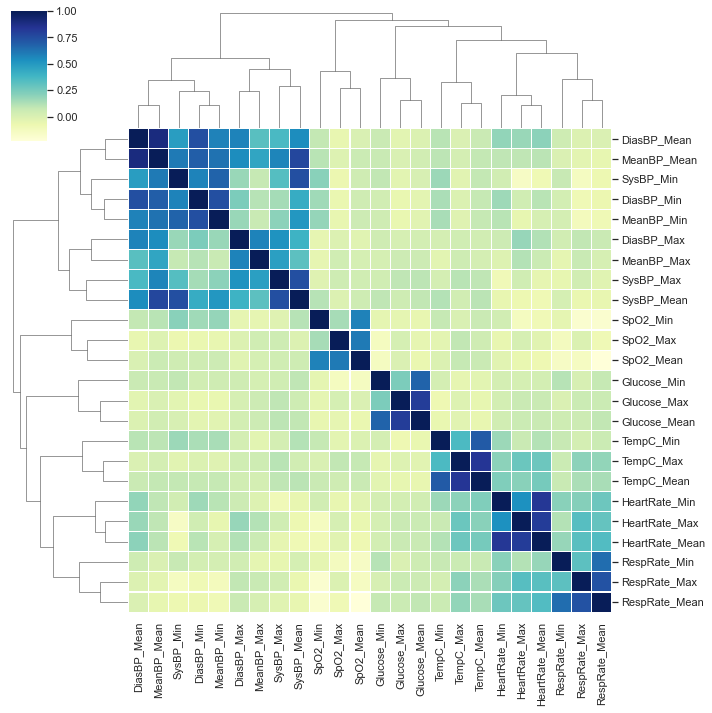

In [129]:
dt_numbers = data.loc[:,numbers]
dt_test_numbers = data_test.loc[:,numbers]
corrmat = dt_numbers.corr() 
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg 

Let's take a closer look at these features. Upon closer inspection most of the corrlations do not appear too high. Nonetheless we shall see if we can reduce dimensionality and still explain a fair share of the variation in the data.

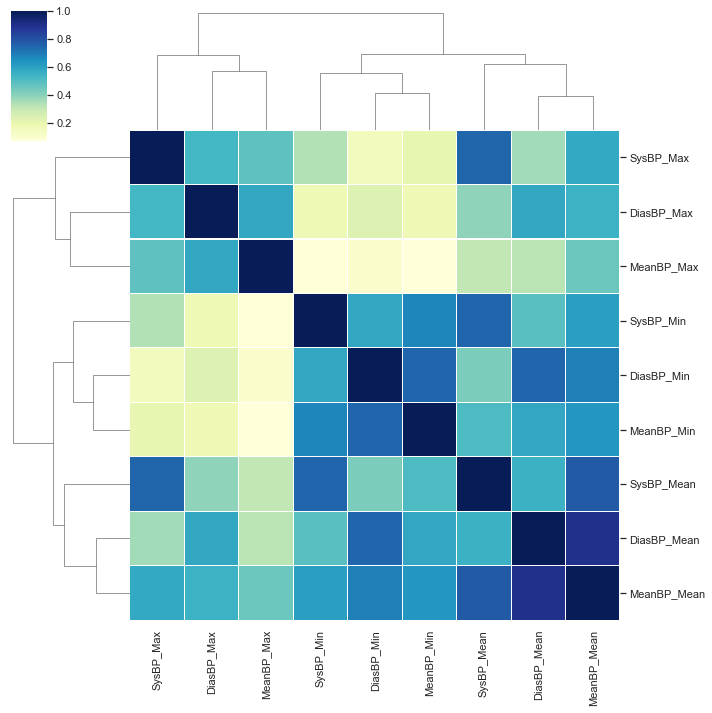

In [130]:
import re
bp_features = list(map(lambda col_name: bool(re.search('BP', col_name)), numbers))
bp_indices = [idx for idx, v in enumerate(bp_features) if v]
bp_features = [numbers[i] for i in bp_indices]
corrmat = dt_numbers.loc[:,bp_features].corr() 
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg

Before running PCA we need to get rid of missing values. `BayesRidge` has shown itself to be very good so I will use this here even before testing different imputer further below for the remaining missing variables.For that purpose I'll introduce a helper function at this point which we shall use extensively below:

In [131]:
# Helper functions for different methods:
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing

# Helper function to slit by type
def make_pipe(X_train, X_test, y_train, imputer, numbers=numbers, categ=categ, multi_cat=multi_cat):
    # Split preprocessing depending on type:
    # 1) Numerical:
    numeric_transformer = Pipeline(
        steps=[
            ('imputer', imputer),
            ('scaler', StandardScaler())
        ]
    )
    # 2) Categorical:
    categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('target', OneHotEncoder(handle_unknown='ignore'))
        ]
    )
    # 3) Multi-level categoricals:
    multi_cat_transformer = Pipeline(
        steps=[
            ('target', ce.TargetEncoder()),
            ('imputer', imputer)
        ]
    )
    # Combine:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numbers),
            ('cat', categorical_transformer, categ),
            ('multi_cat', multi_cat_transformer, multi_cat)
        ],
        remainder='drop'
    )
    # Fit and transform:
    preprocessor.fit(X_train, y_train)
    X_train_proposed=preprocessor.transform(X_train)
    X_test_proposed=preprocessor.transform(X_test)
    # Turn back into DataFrames:
    try:
        X_train_proposed = pd.DataFrame.sparse.from_spmatrix(
            X_train_proposed #, columns= list(numbers) + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names(categ))
        )
        X_test_proposed = pd.DataFrame.sparse.from_spmatrix(
            X_test_proposed #, columns= list(numbers) + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names(categ))
        )
    except AttributeError:
        X_train_proposed = pd.DataFrame(
            X_train_proposed
        )
        X_test_proposed = pd.DataFrame(
            X_test_proposed
        )
    return X_train_proposed, X_test_proposed

Using this helper function we can implement Bayes Ridge as follows:

In [132]:
# 8) Bayesian Ridge:
def bayes_ridge(X_train, X_test, y_train, max_iter=30, add_indicator=True, numbers=numbers, categ=categ, multi_cat= multi_cat):
    # Imputation for numerical cols:
    imputer=IterativeImputer(random_state=0, estimator=BayesianRidge(), max_iter=max_iter, add_indicator=add_indicator)
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer=imputer, numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

PCA can be readily implemented in Python using the `prince` package. It turns out that the first $5$ principal components explain more than $90%$ of the overall variation in the $9$ features (see below). KNN in particular is sensitive to high dimensionality (see [here](https://towardsdatascience.com/k-nearest-neighbors-and-the-curse-of-dimensionality-e39d10a6105d)) so reducing the number of features from $9$ to $5$ could be beneficial. In the context of the usual bias-variance tradeoff, reducing the number of features will reduce the overall variance at the cost of potentially higher bias.

In [133]:
import prince
pca = prince.PCA(
    n_components=5,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
dt_bp = data.loc[:,bp_features]
dt_test_bp = data_test.loc[:,bp_features]
dt_bp, dt_test_bp = bayes_ridge(dt_bp, dt_test_bp, y_train=y, numbers=bp_features, categ=[], multi_cat=[])
pca = pca.fit(dt_bp)
sum(pca.explained_inertia_)

0.9464263943746192

In [134]:
numbers = [i for i in numbers if i not in bp_features] 
dt_bp = pca.transform(dt_bp)
dt_test_bp = pca.transform(dt_test_bp)
dt_bp.columns = ["bp"+str(i) for i in dt_bp.columns]
dt_test_bp.columns = dt_bp.columns

Similary to features involving blood pressure, variables revolving around the heart and respiration rate also excert positive correlations. Much as above we shall therefore apply PCA.

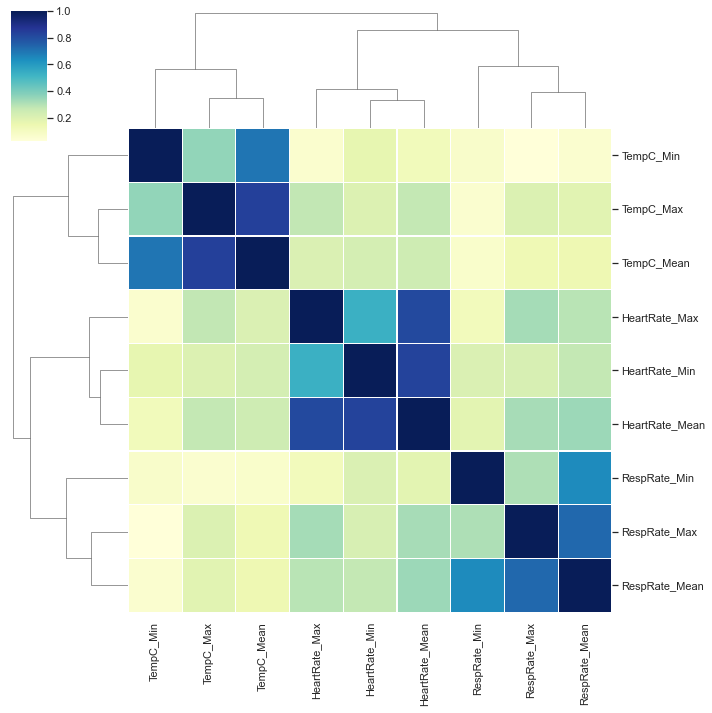

In [135]:
rate_features = list(map(lambda col_name: bool(re.search('Temp', col_name)) + bool(re.search('Rate', col_name)), numbers))
rate_indices = [idx for idx, v in enumerate(rate_features) if v]
rate_features = [numbers[i] for i in rate_indices]
corrmat = data.loc[:,rate_features].corr() 
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg

Once again the first $5$ principal components explain more than $90%$ of the overall variation in the $9$ features. 

In [136]:
import prince
pca = prince.PCA(
    n_components=5,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
dt_rate = data.loc[:,rate_features]
dt_test_rate = data_test.loc[:,rate_features]
dt_rate, dt_test_rate = bayes_ridge(dt_rate, dt_test_rate, y_train=y, numbers=rate_features, categ=[], multi_cat=[])
pca = pca.fit(dt_rate)
sum(pca.explained_inertia_)

0.9133474405466308

In [137]:
numbers = [i for i in numbers if i not in rate_features] 
dt_rate = pca.transform(dt_rate)
dt_test_rate = pca.transform(dt_test_rate)
dt_rate.columns = ["rate"+str(i) for i in dt_rate.columns]
dt_test_rate.columns = dt_rate.columns

### 2.) Discrete features

#### MCA

*Note: I ultimately have not used this approach as alternative ways of dealing with the categorical features yielded better predictions. Still MCA is an interesting idea and might well be useful in other situations*

We have a number of interesting categorical variables in our data set that we want to make use of. Unfortunately, simply one-hot-encoding all of them leads to very high dimensionality. One approach to possibly get around this issue is carry over ideas for dimensionality reduction with continuous variables to the discrete variables case. In particular we could use MCA on the categorical features: this boils down to first turning our data into a *complete disjunctive table* and then applying PCA (see [here](https://en.wikipedia.org/wiki/Multiple_correspondence_analysis)).

In [138]:
cat_dt = data.loc[:,categ]
cat_test_dt = data_test.loc[:,categ]
cat_dt.head()

,ADMISSION_TYPE,FIRST_CAREUNIT,GENDER,INSURANCE,MARITAL_STATUS
0,EMERGENCY,MICU,F,Medicare,SINGLE
1,EMERGENCY,MICU,F,Private,MARRIED
2,EMERGENCY,MICU,F,Medicare,SEPARATED
3,ELECTIVE,SICU,F,Medicare,WIDOWED
4,EMERGENCY,TSICU,F,Medicare,WIDOWED


A good package to do this in Python is `prince`. We simply take our categorical data, specify a number $N$ of principal components to look at and run the MCA. 

In [139]:
import prince
# Run MCA ----
N = 15
mca = prince.MCA(
    n_components=N,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
mca = mca.fit(cat_dt)
cat_dt = mca.transform(cat_dt) 

It turns out that using the first 15 principal components we can explain more than 90% of the variation in the categorical data. Next we will turn to the `ICD9_diagnosis` column, which has more than 6000 distinct levels, so here we have to do some more work (we will take a more targeted approach and relate the diagnosis directly to the outcome variable).

In [140]:
sum(mca.explained_inertia_)

0.9349202981074051

We will do the same for the test data. (Unlike with PCA I noted that for MCA both the column and row dimensions need to check out in order for the transformation to work. PCA only depends on eigenvectors which are of the column dimension of the data. MCA also depends on building a *complete disjunctive table* which seems to also depend on the row dimensions).

In [141]:
mca_test = mca.fit(cat_test_dt)
cat_test_dt = mca_test.transform(cat_test_dt) 
categ = [] # left categorical variables

In [142]:
cat_dt.columns = ["mca"+str(i) for i in cat_dt.columns]
cat_test_dt.columns = cat_dt.columns

#### Multi-level categorical features

As flagged above there are a number of categorical features with many levels. Simply one-hot-encoding them would lead to excessive dimensionality. Instead we will use target encoding for those variables.

#### Extra data

In [143]:
extra_data=pd.read_csv('../Data/extra_data/MIMIC_diagnoses.csv')

In [144]:
extra_data.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [145]:
data.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

### 3.) Feature engineering

With a little bit of extra work we can turn some of the features relating to dates/time into valuable features for prediction.

In [146]:
# Helper functions:
def get_date(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').date()

def time_difference(delta_int):
    return pd.to_timedelta(delta_int, unit='days')

##### Admission time

*Note: Ultimately not used in prediction since no gain.*

In [147]:
data = data.assign(admittime=lambda x: x.ADMITTIME.apply(get_date) + x.Diff.apply(time_difference))
data_test = data_test.assign(admittime=lambda x: x.ADMITTIME.apply(get_date) + x.Diff.apply(time_difference))

/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


##### Age

To get the patients' age at the time of visit we can use the `DOB` column with some corrections:

In [148]:
median_age = 91.4
median_age_days = datetime.timedelta(median_age*365.25)
data['birthdate'] = data.DOB.apply(get_date) + data.Diff.apply(time_difference)
data_test['birthdate'] = data_test.DOB.apply(get_date) + data_test.Diff.apply(time_difference)
data.birthdate = data.birthdate.apply(lambda x: x + datetime.timedelta(300*365.25) - median_age_days if x.year<1900 else x)
data_test.birthdate = data_test.birthdate.apply(lambda x: x + datetime.timedelta(300*365.25) - median_age_days if x.year<1900 else x)
data['age'] = (data.admittime - data.birthdate) / np.timedelta64(1, 'Y')
data_test['age'] = (data_test.admittime - data_test.birthdate) / np.timedelta64(1, 'Y')
# Add to set of predictor variables
numbers += ['age']

##### Seasonality

Following Simon's suggestions in class I add a seasonality feature.

In [149]:
data['month'] = data['admittime'].apply(lambda x: x.month)
data_test['month'] = data_test['admittime'].apply(lambda x: x.month)
months = pd.DataFrame(data.copy().month.sort_values().reset_index(drop=True))
months['sin_month'] = np.sin(2*np.pi*months.month/12)
months['cos_month'] = np.cos(2*np.pi*months.month/12)
data['sin_month'] = np.sin(2*np.pi*data.month/12)
data['cos_month'] = np.cos(2*np.pi*data.month/12)
data_test['sin_month'] = np.sin(2*np.pi*data.month/12)
data_test['cos_month'] = np.cos(2*np.pi*data.month/12)
numbers += ['sin_month', 'cos_month']

### 4.) Merge in new features

With all of that done, let us merge the new information into the data set. We'll also get rid of any variables we do not care about. Numerical and categorical features already in the data set (or recently merged into it) include the following:

In [150]:
features = list(numbers) + list(categ) + list(multi_cat)
features

['SpO2_Min',
 'SpO2_Max',
 'SpO2_Mean',
 'Glucose_Min',
 'Glucose_Max',
 'Glucose_Mean',
 'age',
 'sin_month',
 'cos_month',
 'ICD9_diagnosis',
 'ETHNICITY',
 'RELIGION']

Now let us also merge in the transformed variables from PCA:

In [151]:
data = pd.concat([data.loc[:,features], dt_bp, dt_rate, cat_dt], axis=1)
data_test = pd.concat([data_test.loc[:,features], dt_test_bp, dt_test_rate, cat_test_dt], axis=1)
#data = pd.concat([data.loc[:,features], dt_bp, dt_rate], axis=1)
#data_test = pd.concat([data_test.loc[:,features], dt_test_bp, dt_test_rate], axis=1)
numbers = data.columns[(data.dtypes ==int) | (data.dtypes ==float)]
features = list(numbers) + list(categ) + list(multi_cat)

## Missing values and scaling

We have already done some missing value imputation above before running PCA. Let's check if some of the non-transformed variables have missing values:

Index(['SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean'],
      dtype='object')

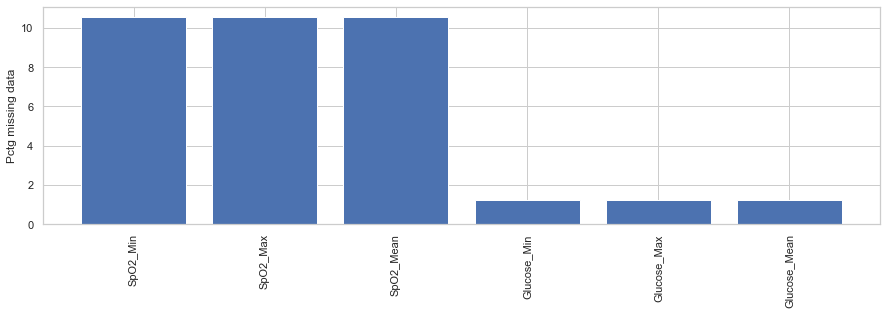

In [152]:
# Report na
# Compute nulls per feature
Nulls= data.isnull().sum()
plt.figure(figsize=(15,4))
plt.xticks(rotation='vertical')
plt.bar(Nulls[Nulls>0].index, 100*Nulls[Nulls>0].values/len(data.index))
plt.ylabel('Pctg missing data')
missing_data_col= data.columns[Nulls>0]
missing_data_col

To choose the best method for missing value imputation I will proceed systematically by essentially running a grid search with a simply classifier (as you suggested).

In [153]:
# Split target data
X = data
#perform training and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
Nulls = X_train.isnull().sum()
missing_data_col = X_train.columns[Nulls>0]
missing_data_col

Index(['SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean'],
      dtype='object')

Initialize a simple log-reg for classification:

In [154]:
# Simple log-reg for classification
from sklearn.linear_model import LinearRegression
lregr = LinearRegression()

Build a couple of helper functions that apply different methods to impute missing values:

In [155]:
# 1) Remove missing:
def remove_na(X_train, X_test, y_train, missing_data_col=missing_data_col, numbers=numbers, categ=categ, multi_cat= multi_cat):
    X_train=X_train.drop(axis=1,labels=missing_data_col)
    X_test=X_test.drop(axis=1,labels=missing_data_col)
    numbers = X_train.columns[(X_train.dtypes == int) | (X_train.dtypes == float)]
    categ = X_train.columns[X_train.dtypes == object]
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer='passthrough', numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 2) Backwards propagate:
def bfill(X_train, X_test, y_train, numbers=numbers, categ=categ, multi_cat= multi_cat):
    X_train.fillna(method='ffill',inplace=True)
    X_test.fillna(method='ffill',inplace=True)
    numbers = X_train.columns[(X_train.dtypes == int) | (X_train.dtypes == float)]
    categ = X_train.columns[X_train.dtypes == object]
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer='passthrough', numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 3) Forwards propagate:
def ffill(X_train, X_test, y_train, numbers=numbers, categ=categ, multi_cat= multi_cat):
    X_train.fillna(method='bfill',inplace=True)
    X_test.fillna(method='bfill',inplace=True)
    numbers = X_train.columns[(X_train.dtypes == int) | (X_train.dtypes == float)]
    categ = X_train.columns[X_train.dtypes == object]
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer='passthrough', numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 4) Replace by value out of range:
def out_of_range_fill(X_train, X_test, y_train, missing_data_col=missing_data_col, factor=10, numbers=numbers, categ=categ, multi_cat= multi_cat):
    for col in missing_data_col:
        extreme = X_train[col].max()*factor
        X_train[col].fillna(extreme,inplace=True)
        X_test[col].fillna(extreme,inplace=True)
    numbers = X_train.columns[(X_train.dtypes == int) | (X_train.dtypes == float)]
    categ = X_train.columns[X_train.dtypes == object]
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer='passthrough', numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 5) Mean:
def mean_fill(X_train, X_test, y_train, numbers=numbers, categ=categ, multi_cat= multi_cat):
    # Imputer:
    imputer=SimpleImputer(strategy='mean')
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer=imputer, numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 6) Median:
def median_fill(X_train, X_test, y_train, numbers=numbers, categ=categ, multi_cat= multi_cat):
    # Imputer:
    imputer=SimpleImputer(strategy='median')
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer=imputer, numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 7) KNN fill:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
def knn_fill(X_train, X_test, y_train, n_neighbors=2, numbers=numbers, categ=categ, multi_cat= multi_cat):
    # Imputer:
    imputer=KNNImputer(n_neighbors=n_neighbors)
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer=imputer, numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 8) Bayesian Ridge:
# (see above)

# 9) Decision tree:
def decision_tree(X_train, X_test, y_train, max_iter=30, add_indicator=True, numbers=numbers, categ=categ, multi_cat= multi_cat):
    # Imputation for numerical cols:
    imputer=IterativeImputer(random_state=0, estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=max_iter, add_indicator=add_indicator)
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer=imputer, numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 10) Extra trees:
def extra_tree(X_train, X_test, y_train, max_iter=30, add_indicator=True, n_estimators=20, numbers=numbers, categ=categ, multi_cat= multi_cat):
    # Imputation:
    imputer=IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators=n_estimators, random_state=0), max_iter=max_iter, add_indicator=add_indicator)
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer=imputer, numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

# 11) KNN:
def knn_iter(X_train, X_test, y_train, max_iter=30, add_indicator=True, n_neighbors=2, numbers=numbers, categ=categ, multi_cat= multi_cat):
    # Imputation:
    imputer=IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=n_neighbors), max_iter=max_iter, add_indicator=add_indicator)
    X_train, X_test = make_pipe(X_train, X_test, y_train, imputer=imputer, numbers=numbers, categ=categ, multi_cat= multi_cat)
    return X_train, X_test

## Compare methods: ----
from sklearn.metrics import mean_squared_error

def compare_methods(classifier, methods, X_train, X_test, y_train, numbers=numbers, categ=categ, multi_cat= multi_cat, results=[], X_filled=[]):
    for i in list(methods.keys()):
        X_train_copy = X_train.copy()
        X_test_copy = X_test.copy()
        try:
            X_train_proposed, X_test_proposed = methods[i](X_train_copy, X_test_copy, y_train, numbers=numbers, categ=categ, multi_cat= multi_cat)
        except TypeError:
            X_train_proposed = X_train_copy
            X_test_proposed = X_test_copy
        X = X_train_proposed
        y = y_train
        # Predict:
        try: 
            classifier.fit(X, y)
            y_hat = classifier.predict(X_test_proposed) 
            # Compute predictions and report AUC_accuracy
            print(i)
            print('MSE : ' + str(mean_squared_error(y_test,y_hat)))
            results += [(i,mean_squared_error(y_test,y_hat))]
            X_filled += [X_train_proposed]
        except ValueError:
            print(i)
            print("Imputation not successful")
            results += [(i,0)]
            X_filled += [0]
    return results, X_filled

Now lets run the comparison:

In [156]:
methods = {
    'remove_na': remove_na,
    'bfill': bfill,
    'ffill': ffill,
    'out_of_range_fill': out_of_range_fill,
    'mean_fill': mean_fill,
    'median_fill': median_fill,
    'knn_fill': knn_fill,
    'bayes_ridge': bayes_ridge,
    'decision_tree': decision_tree
    #'extra_tree': extra_tree, # took too long
    # 'knn_iter': knn_iter # took too long
}
results, X_filled = compare_methods(lregr, methods, X_train, X_test, y_train, numbers=numbers, categ=categ, multi_cat= multi_cat)
results_df=pd.DataFrame(results)
results_df.columns=['Method','MSE']
results_df= results_df.sort_values(by='MSE', ascending=True)
results_df.head()

/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


remove_na
MSE : 23.81498164008269


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


bfill
MSE : 23.601602878238634


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


ffill
MSE : 23.592605373661623


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


out_of_range_fill
MSE : 23.558232451756428


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


mean_fill
MSE : 22.759169127411635


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


median_fill
MSE : 22.75739534925134


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


knn_fill
MSE : 22.75345511445925


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


bayes_ridge
MSE : 22.707322424035546


/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


decision_tree
MSE : 23.27368329447017


,Method,MSE
7,bayes_ridge,22.707322
6,knn_fill,22.753455
5,median_fill,22.757395
4,mean_fill,22.759169
8,decision_tree,23.273683


(22.0, 23.0)

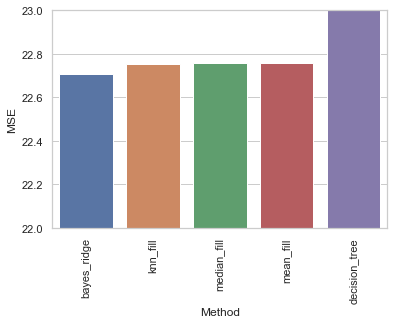

In [157]:
sns.set(style="whitegrid")
ax = sns.barplot(x="Method", y="MSE", data=results_df.head())
ax= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
best_imputer = results_df.head(1)
plt.ylim(22, 23)

In [158]:
best_imputer_score = best_imputer.MSE
best_imputer_name = best_imputer.loc[:,'Method'].values[0]

#### 2.) Perform imputation and scaling

Now that we have chosen a preferred method for imputation, let us actually perform imputationa and scaling.

In [159]:
X=data
X_test=data_test
print(X_test.columns)
print(X.columns)

Index(['SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'age', 'sin_month', 'cos_month', 'ICD9_diagnosis',
       'ETHNICITY', 'RELIGION', 'bp0', 'bp1', 'bp2', 'bp3', 'bp4', 'rate0',
       'rate1', 'rate2', 'rate3', 'rate4', 'mca0', 'mca1', 'mca2', 'mca3',
       'mca4', 'mca5', 'mca6', 'mca7', 'mca8', 'mca9', 'mca10', 'mca11',
       'mca12', 'mca13', 'mca14'],
      dtype='object')
Index(['SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'age', 'sin_month', 'cos_month', 'ICD9_diagnosis',
       'ETHNICITY', 'RELIGION', 'bp0', 'bp1', 'bp2', 'bp3', 'bp4', 'rate0',
       'rate1', 'rate2', 'rate3', 'rate4', 'mca0', 'mca1', 'mca2', 'mca3',
       'mca4', 'mca5', 'mca6', 'mca7', 'mca8', 'mca9', 'mca10', 'mca11',
       'mca12', 'mca13', 'mca14'],
      dtype='object')


In [160]:
#X, X_test = methods[best_imputer_name](X,X_test, numbers=numbers, categ=categ)
X, X_test = methods[best_imputer_name](X,X_test,y_train=y, numbers=numbers, categ=categ, multi_cat=multi_cat)
X_colnames=X.columns

/Users/patrickaltmeyer/.pyenv/versions/3.8.0/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### 3.) Shrinkage

I found that adding additional features generally reduced overall model performance. As an additional guide towards model selection I therefore run a simple LASSO regression to detect insignificant features.

In [161]:
#from sklearn import linear_model
#clf = linear_model.Lasso(alpha=0.1)
#clf.fit(X,y)
#coefficients = pd.DataFrame({'variable': X.columns, 'coeff': clf.coef_})
#coefficients= coefficients.sort_values(by='coeff', ascending=False)
#col_to_use = coefficients[coefficients.coeff!=0].variable.values
#X = X[col_to_use]

##### Sanity checks

In [162]:
## Make sure train and test set have same dimension:
#col_to_use = X.columns[X.columns.isin(X_test.columns)]
#len(col_to_use)
#X = pd.concat([X[col_to_use]], axis=1)
#X_test = X_test[col_to_use]

##### Export

In [163]:
X.shape

(20885, 43)

In [164]:
X.to_csv('../Data/los/X_preproc.csv', index=False)
X_test.to_csv('../Data/los/X_test_preproc.csv', index=False)